In [ ]:
# created by GO 20230613
# purpose: get confidence around trends in temp at Nanoose

# data in: bimonthly anomalies, model and observations for salt and temp
#          as NetCDF (data from Visuals-Data - CTD Obs, Mod at Nanoose (Blind))

# last modified: 20230802
# done: streamline flow and update to run216 (change names out in previous notebook)

In [121]:
import os
import xarray as xr

import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

import time
import datetime as dt

from scipy import interpolate

In [122]:
# Function to compute the slope of the linear trend
def compute_slope(x, y):
    regression = LinearRegression()
    regression.fit(x, y)
    return regression.coef_[0]

def compute_slope_GO(x,y):
    m, c = np.linalg.lstsq(x, y, rcond=None)[0]
    return m, c

def get_bootstrapped_CI(n_iter, ts, ts_time):
#     values = ts.values[~np.isnan(ts.values)]
    values = ts[~np.isnan(ts)]
    #time = ts_time[~np.isnan(ts.values)]
    time = ts_time[~np.isnan(ts)]
    # Fit linear regression to the original data
    # regression = LinearRegression()
    # regression.fit(time.reshape(-1, 1), values)
    A = np.vstack([time, np.ones(len(time))]).T
    orig_slope, orig_bias = compute_slope_GO(A,values)

    # Initialize an array to store the slopes
    bootstrap_slopes = np.zeros(n_iter)
    bootstrap_biases = np.zeros(n_iter)

    # Perform bootstrapping
    for i in range(n_iter):

        # Generate a bootstrap sample by resampling with replacement
        indices = np.random.choice(len(values), len(values), replace=True)
        bootstrap_sample = values[indices]
        bootstrap_time = time[indices]
        A = np.vstack([bootstrap_time, np.ones(len(bootstrap_time))]).T

        # Compute the slope of the linear trend on the bootstrap sample
    #     bootstrap_slope = compute_slope_GO(bootstrap_time.reshape(-1, 1), bootstrap_sample)
        bootstrap_slope, bootstrap_b = compute_slope_GO(A, bootstrap_sample)
        bootstrap_slopes[i] = bootstrap_slope
        bootstrap_biases[i] = bootstrap_b
        
    return bootstrap_slopes, bootstrap_biases, orig_slope, orig_bias

def plot_trend(ax, tyr, tempdata, n_iterations, 
               bs_slopes, bs_biases, orig_slope, 
               orig_bias, lbl,
               max_y=1,
               min_y=-1
              ):
    
#     ax.plot(tyr,tempdata.values,linewidth = 0.5, alpha = 0.5)
    ax.plot(tyr,tempdata,linewidth = 0.5, alpha = 0.5)

#     x = tyr[~np.isnan(tempdata.values)]
#     y = tempdata.values[~np.isnan(tempdata.values)]
    
    x = tyr[~np.isnan(tempdata)]
    y = tempdata[~np.isnan(tempdata)]
    
    # A = np.vstack([x, np.ones(len(x))]).T
    # m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
    ax.plot(x, y, '.', label=lbl, markersize=2)
    
    # Plot the linear regression lines from the bootstrap samples
    for i in range(n_iterations):
        if i == 0:
            ax.plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
        else:
            ax.plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

    ax.plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')
    
    ax.set_ylim(min_y, max_y)  
    
    # reorder legend
    plt.sca(ax)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
    ax.axhline(y=0)
    ax.grid()

In [84]:
print("weighted mean: " + str(np.sum(depth_weights * obs_gt4mtemp[:,0])))
# print("non weighted mean: " + obs_gt4mtemp.mean(dim=0))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [107]:
weights_newshape = depth_weights[:, np.newaxis]
weighted_mean = np.nansum((obs_gt4mtemp * weights_newshape),axis=0)
weighted_mean

array([ 9.85818806e-03,  0.00000000e+00, -9.13785331e-02, -1.79417577e-01,
       -1.41960603e-01, -2.29698342e-01, -2.11621964e-01, -1.94917185e-01,
       -1.36342271e-01, -2.03657302e-01, -2.35464819e-01, -1.72899539e-01,
       -2.01885994e-01,  0.00000000e+00, -1.26420212e-01, -8.72516963e-02,
       -1.87327905e-01, -7.48648098e-02, -7.02372784e-02, -1.06823942e-01,
       -9.70940711e-02, -1.10102793e-01, -9.07075224e-02, -1.11749268e-01,
       -3.34535123e-02,  4.42551904e-02,  1.26742195e-01,  1.75582459e-01,
        1.93783875e-01,  2.52211637e-01,  2.88247855e-01,  2.96338839e-01,
        3.76274519e-01,  2.81826882e-01,  1.76003442e-01,  1.84632374e-01,
        9.32406812e-02,  1.23189150e-01,  4.07050645e-02,  2.76757122e-03,
        3.35548070e-03, -4.85272903e-02, -5.02281125e-02, -5.65304929e-02,
       -3.25354895e-02,  0.00000000e+00,  3.24796109e-02, -1.22196795e-01,
       -2.13276182e-01,  1.27519485e-02,  8.53234920e-02, -2.79578576e-03,
       -1.33143423e-02,  

In [120]:
# np.nansum(obs_gt4mtemp[:,0] * depth_weights)
obs_gt4mtemp[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [191]:
dep_min = 4
dep_max = 387
dat = obs_gt4mtemp.values[:,0]

diffs = np.abs(deptht - dep_min)
min_closest_idx = np.argmin(diffs)
if min_closest_idx == 0:
    first_bin_halfwidth = deptht[0]
else:
    # Find idx w/ the min diff
    first_bin_halfwidth = (deptht[min_closest_idx] - deptht[min_closest_idx - 1]) / 2

# finding the final bin half-width
diffs = np.abs(deptht - dep_max)
max_closest_idx = np.argmin(diffs)
last_bin_halfwidth = (deptht[max_closest_idx] - deptht[max_closest_idx - 1]) / 2

deptht_trunc = deptht[min_closest_idx:max_closest_idx]
depth_diffs = np.diff(deptht_trunc) / 2 # 1/2 the dist b/w each t depth lev (bin boundary)
depth_bins = np.insert(depth_diffs, 0, first_bin_halfwidth) # inserts the first half bin
last_bin_halfwidth = depth_diffs[-1]
depth_bins = np.insert(depth_bins, -1, last_bin_halfwidth) # inserts the last half bin
depth_widths = depth_bins[:-1] + depth_bins[1:]
sum_depths = np.sum(depth_widths)
depth_weights = depth_widths / sum_depths

# get weighted average
weights_newshape = depth_weights[:, np.newaxis]
dep_avg = np.nansum((dat * depth_weights),axis=0)

In [192]:
dep_avg

-0.006836820895597579

(34,)

In [213]:
print(gdept_0[0,:,175, 75])
print(tmask[0,:, 175, 75])
print(e3t0[0,:, 175, 75])

[  0.5000003   1.5000031   2.5000114   3.5000305   4.5000706   5.5001507
   6.5003104   7.500623    8.501236    9.502433   10.5047655  11.509312
  12.518167   13.535412   14.568982   15.634288   16.761173   18.007135
  19.481785   21.389978   24.100256   28.229916   34.685757   44.517723
  58.484333   76.58559    98.06296   121.866516  147.08946   173.11449
 199.57304   226.2603    253.06664   279.93454   298.58588   308.9961
 360.67453   387.6032    414.5341    441.4661   ]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0]
[ 1.00000115  1.00000501  1.00001253  1.00002718  1.0000557   1.00011125
  1.00021946  1.0004302   1.00084067  1.00164012  1.0031971   1.00622914
  1.01213271  1.02362358  1.04597551  1.08940061  1.17356428  1.33592899
  1.64636781  2.22990285  3.29248567  5.11998508  7.97451506 11.8252972
 16.10792044 19.95870258 22.81323256 24.64073198 25.70331479 26.28684983
 26.59728865 26.75965336 26.84381704 26.88724213 10.41023144 10.41023144


In [260]:

def nanmean_vvl(d, mDep):
    # d - data already truncated to depth range
    # mDep - model deps
    
    # watch out for nans
    mDep = mDep[~np.isnan(d)]
    d=d[~np.isnan(d)]
    
    integration = np.trapz(d, mDep)
    depth_range = mDep[-1] - mDep[0]
    avg_weighted = integration / depth_range
    
    return avg_weighted


# def nanmean_e3t(d, mDep, drange, e3t0, tmask)
#     #find indices closest to max and min and create mask 
#     #set vars (t,u,v,w?)
#     diffs_min = np.abs(mDep - drange[0])
#     min_idx = np.argmin(diffs_min)
#     dg_mask = np.zeros(mDep, dtype=int)  # Initialize the mask with zeros
    
#     if drange[1] is None:
#         dg_mask[min_idx:] = 1
#     else:
#         diffs_max = np.abs(mDep - dep_max)
#         max_idx = np.argmin(diffs_max)
#         dg_mask[min_idx:max_idx + 1] = 1
      
#     dg_mask = dg_mask[np.newaxis, :, np.newaxis, np.newaxis]
#     masked_dataarray = dat.copy()
#     masked_dataarray = masked_dataarray.where(dmask, drop=False, other=0) # 0's where z exceeds water col max
#     masked_dataarray = masked_dataarray.where(dg_mask, drop=False, other=0) # 0's where z is not within group range
    
#     e30_2 = e30 * dmask * dg_mask
#     e30_2_sum = np.sum(e30_2, axis=1, keepdims=True)
#     e30_weights = e30_2 / e30_2_sum
#     weighted_data = masked_dataarray * e30_weights # weight the values by depth bin widths

#     final_avg = np.sum(weighted_data, axis=1, keepdims=True)
    
#     return final_avg

import netCDF4 as nc
meshm_p = '../data/mesh mask/'
meshm_f = 'mesh_mask_20210406.nc'

with nc.Dataset(os.path.join(meshm_p, meshm_f)) as mesh:
#     print(mesh.variables)
    tmask=mesh.variables['tmask'][:] # 0's where depth lev exceeds
    umask=mesh.variables['umask'][:]
    vmask=mesh.variables['vmask'][:]
    fmask=mesh.variables['fmask'][:]
    e3t0=mesh.variables['e3t_0'][:] # 'widths' or 'weights' for each depth lev
    e3u0=mesh.variables['e3u_0'][:]
    e3v0=mesh.variables['e3v_0'][:]
    e3w0=mesh.variables['e3w_0'][:]
    gdept_0=mesh.variables['gdept_0'][:]

# dat is temp anom over depth (shape: 34,) and already been truncated to 3.5 m ->
dat = obs_gt4mtemp[:,0].values
# nan value is at 4.5 m
# [      nan,  0.414497,  0.436157,  0.440326,  0.438124,  0.435652,
#         0.456881,  0.50175 ,  0.60882 ,  0.670105,  0.687495,  0.692896,
#         0.6863  ,  0.664693,  0.631454,  0.583905,  0.55397 ,  0.486506,
#         0.440876,  0.345747,  0.191192,  0.146218, -0.029908,  0.130583,
#         0.121402,  0.051352, -0.132174, -0.152257, -0.182029, -0.185742,
#        -0.167947, -0.135024, -0.103975, -0.10505 ]

# pretend the data is more typical: 
# model data at one location

# depths, tmask, and e3t0 at nanoose:
gdept_0 = gdept_0[0,:,175, 75]
e3t0 = e3t0[0,:,175, 75]
tmask = tmask[0,:,175, 75]

# depth range in metres
depth_min = 4.2
depth_max = 387

# find closest deptht to the min depth
diffs_min = np.abs(gdept_0 - depth_min)
min_idx = np.argmin(diffs_min)
diffs_max = np.abs(gdept_0 - depth_max)
max_idx = np.argmin(diffs_max)

# create mask for the depth range
dg_mask = np.zeros(gdept_0.shape, dtype=int)        
dg_mask[min_idx:max_idx+1] = 1

# data is already truncated
# dat_masked = dat.copy()
# dat_masked = dat_masked.where(dg_mask, drop=False, other=0) # 0's where z is not within group range
# dat_masked = dat_masked.where(tmask, drop=False, other=0) # 0's where z exceeds water col max
# print(dat_masked)

# truncate the e3t0 vector
e3t0_2 = e3t0 * tmask * dg_mask
e3t0_2_sum = np.sum(e3t0_2, axis=0, keepdims=True)
e3t0_weights = e3t0_2 / e3t0_2_sum

# step because example data is odd
e3t0_weights = e3t0_weights[min_idx:max_idx+1] # truncate to match data

weighted_data = dat * e3t0_weights # weight the values by depth bin widths
final_avg = np.nansum(weighted_data, axis=0, keepdims=True)
print('simple mean is: ', np.nanmean(dat))
print('using e3t0 the weighted mean is: ', final_avg)

# np.trapz
gdept_0 = gdept_0[min_idx:max_idx+1]
integral = np.trapz(dat, gdept_0)
depth_range = gdept_0[-1] - gdept_0[0]
avg_weighted = integral / depth_range
print('the mean using np.trapz: ', avg_weighted)

simple mean is:  0.2915998067418136
using e3t0 the weighted mean is:  [0.05218560564168273]
the mean using np.trapz:  0.015994166710755986


In [258]:
# # mDep = np.asarray([10,15,25,40,65,90])
# mDep = np.asarray([10,15,25,40,65,90,120])
# # drange = np.asarray([9,100])

# print(nanmean_vvl(dat, mDep))

(40,)

In [203]:
datt

array([10,  8,  7,  6,  5,  5])

Original slope: 0.0034
95% Confidence Interval: 0.0018 to 0.0049
Is the trend significant at the 95% level? Yes
Original slope: 0.0033
95% Confidence Interval: 0.0015 to 0.0051
Is the trend significant at the 95% level? Yes
Original slope: 0.0034
95% Confidence Interval: 0.0018 to 0.0052
Is the trend significant at the 95% level? Yes
Original slope: 0.0017
95% Confidence Interval: 0.0003 to 0.0034
Is the trend significant at the 95% level? Yes


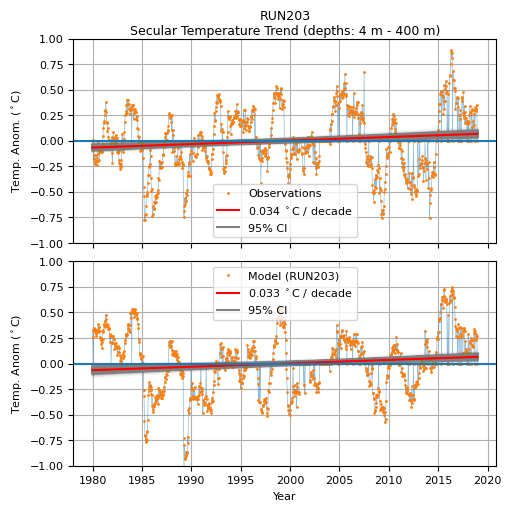

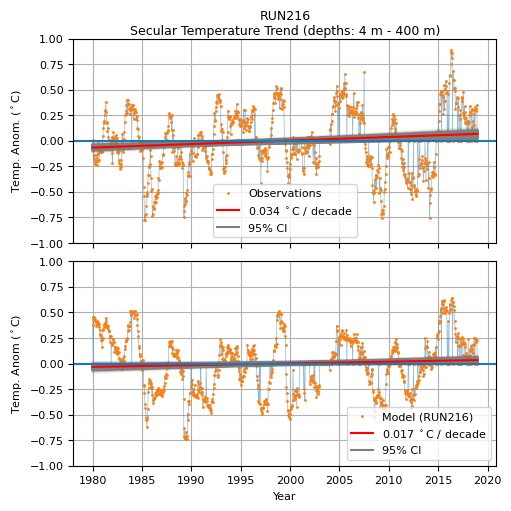

In [88]:
   
##############################################
modelruns_info = {'SalishSea1500-RUN203': {'path': './climatol_intermediate_files/',
                                           'shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': './climatol_intermediate_files/',
                                           'shortcode': 'RUN216'}
                 }


# need to average by depths - select min dept
min_d = 4
max_d = 400
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000
tyr = np.arange(1980,2019,(1/24))
# plot size scalar
fact = 1

m = 0
for model in modelruns_info.keys():
    mod_run = modelruns_info[model]['shortcode']
    path1 = modelruns_info[model]['path']
    
    # get weights for averaging based on widths of depth bins
    deptht = obs_anom_t.deptht
    shallow_lim_idx = 3 # 4.5 metres and deeper
    first_bin_halfwidth = deptht[shallow_lim_idx] - deptht[shallow_lim_idx - 1]
    deptht_trunc = deptht.isel(deptht = (obs_anom_t.deptht >= min_d) & (obs_anom_t.deptht < max_d))
    depth_diffs = np.diff(deptht_trunc)
    depth_diffs = depth_diffs / 2 # gives one half the distance between each t depth lev (bin boundary)
    depth_bins = np.insert(depth_diffs, 0, first_bin_halfwidth) # inserts the first half bin
    last_bin_halfwidth = depth_diffs[-1]
    depth_bins = np.insert(depth_bins, -1, last_bin_halfwidth) # inserts the last half bin (assumes same width as second last)
    depth_widths = depth_bins[:-1] + depth_bins[1:]
    sum_depths = np.sum(depth_widths)
    depth_weights = depth_widths / sum_depths
    
    # get weighted average
    weights_newshape = depth_weights[:, np.newaxis]
    obs_gt4mtemp = np.nansum((obs_gt4mtemp * weights_newshape),axis=0)
    mod_gt4mtemp = np.nansum((mod_gt4mtemp * weights_newshape),axis=0)
    
    fig, axs = plt.subplots(2,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
    axs = axs.ravel()
    
    ####################################
    #bootstrap analysis - obser
    bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_gt4mtemp, tyr)
    confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
    # Check if the original slope is within the confidence interval
    is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
    # Print the results
    print(f"Original slope: {orig_slope:.4f}")
    print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
    print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
    
    lbl = "Observations"
    plot_trend(axs[0], tyr, obs_gt4mtemp, n_iterations, bs_slopes, bs_biases, orig_slope, orig_bias, lbl)
    
    ####################################
    #bootstrap analysis - model
    bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_gt4mtemp, tyr)
    confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
    # Check if the original slope is within the confidence interval
    is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
    # Print the results
    print(f"Original slope: {orig_slope:.4f}")
    print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
    print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")

    lbl = "Model (" + mod_run + ")"
    plot_trend(axs[1], tyr, mod_gt4mtemp, 
               n_iterations, 
               bs_slopes, 
               bs_biases, 
               orig_slope, 
               orig_bias, 
               lbl)
    
    # reorder legend
#     plt.sca(axs[1])
#     handles, labels = plt.gca().get_legend_handles_labels()
#     order = [0,2,1]
#     axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
#     axs[1].axhline(y=0)
#     axs[1].grid()

    axs[0].set_title(mod_run + '\nSecular Temperature Trend (depths: ' + str(min_d) + ' m - ' + str(max_d) + ' m)', fontsize=9, pad=3)
    axs[0].set_xlabel('')
    axs[0].tick_params(axis='x', labelbottom=False)
    axs[0].tick_params(axis='y', labelsize=8)
    axs[1].tick_params(axis='x', labelbottom=True, labelsize=8)
    axs[1].tick_params(axis='y', labelsize=8)
    axs[1].set_xlabel('Year', fontsize=8)
    axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
    axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)

In [34]:

deptht = obs_anom_t.deptht
    shallow_lim_idx = 3 # 4.5 metres and deeper
    first_bin_halfwidth = deptht[shallow_lim_idx] - deptht[shallow_lim_idx - 1]
    deptht_trunc = deptht.isel(deptht = (obs_anom_t.deptht >= min_d) & (obs_anom_t.deptht < max_d))
    depth_diffs = np.diff(deptht_trunc)
    depth_diffs = depth_diffs / 2 # gives one half the distance between each t depth lev (bin boundary)
    depth_bins = np.insert(depth_diffs, 0, first_bin_halfwidth) # inserts the first half bin
    last_bin_halfwidth = depth_diffs[-1]
    depth_bins = np.insert(depth_bins, -1, last_bin_halfwidth) # inserts the last half bin (assumes same width as second last)
    depth_widths = depth_bins[:-1] + depth_bins[1:]
    sum_depths = np.sum(depth_widths)
    depth_weights = depth_widths / sum_depths

2

In [109]:
deptht

array([  0.5000003 ,   1.5000031 ,   2.50001144,   3.50003052,
         4.50007057,   5.50015068,   6.50031042,   7.50062323,
         8.50123596,   9.50243282,  10.50476551,  11.50931168,
        12.51816654,  13.53541183,  14.56898212,  15.63428783,
        16.76117325,  18.00713539,  19.48178482,  21.38997841,
        24.10025597,  28.22991562,  34.68575668,  44.51772308,
        58.48433304,  76.58558655,  98.06295776, 121.86651611,
       147.08946228, 173.11448669, 199.57304382, 226.26029968,
       253.06663513, 279.93453979, 306.834198  , 333.75018311,
       360.67453003, 387.60321045, 414.53408813, 441.46609497])

In [ ]:
# old code draft below

In [2]:
path1 = './climatol_intermediate_files/'
mod_run = "RUN203"
mod_run = "RUN216"
# mod_s_clim_f = 'mod_' + mod_run + '_salinity_1980-2018-climatology.nc'
# mod_t_clim_f = 'mod_' + mod_run + '_temperature_1980-2018-climatology.nc'
# mod_s_bm_f = 'mod_' + mod_run + 'salinity_1980-2018-bimonthly_timeseries.nc'
# mod_t_bm_f = 'mod_' + mod_run + 'temperature_1980-2018-bimonthly_timeseries.nc'

# # climatology and bimonthly time series of temp, salt
# mod_s_clim = xr.open_dataset(os.path.join(path1,mod_s_clim_f))
# mod_t_clim = xr.open_dataset(os.path.join(path1,mod_t_clim_f))
# mod_s_bm = xr.open_dataset(os.path.join(path1,mod_s_bm_f))
# mod_t_bm = xr.open_dataset(os.path.join(path1,mod_t_bm_f))

# # climatol and bm ts from Nanoose data
# obs_ts_bm_f = 'ctd_ts_timeseries_bimonthly.nc'
# obs_s_clim_f = 'obs_salinity_1980-2018-bimonthly_timeseries.nc'
# obs_t_clim_f = 'obs_temperature_1980-2018-bimonthly_timeseries.nc'

# obs_ts_bm = xr.open_dataset(os.path.join(path1,obs_ts_bm_f))
# obs_s_clim = xr.open_dataset(os.path.join(path1,obs_s_clim_f))
# obs_t_clim = xr.open_dataset(os.path.join(path1,obs_t_clim_f))

obs_anom_t_f = mod_run + 'obs_anom_temp_1980-2018.nc'
obs_anom_s_f = mod_run + 'obs_anom_salt_1980-2018.nc'
mod_anom_t_f = mod_run + 'mod_anom_temp_1980-2018.nc'
mod_anom_s_f = mod_run + 'mod_anom_salt_1980-2018.nc'
obs_anom_t = xr.open_dataset(os.path.join(path1,obs_anom_t_f))
obs_anom_s = xr.open_dataset(os.path.join(path1,obs_anom_s_f))
mod_anom_t= xr.open_dataset(os.path.join(path1,mod_anom_t_f))
mod_anom_s = xr.open_dataset(os.path.join(path1,mod_anom_s_f))    
    

In [10]:
# need to average by depths - select min dept
min_d = 4
obs_gt4mtemp = obs_anom_t.isel(deptht = obs_anom_t.deptht >min_d).mean(dim = 'deptht')
mod_gt4mtemp = mod_anom_t.isel(deptht = obs_anom_s.deptht >min_d).mean(dim = 'deptht')
obs_gt4mtemp = obs_gt4mtemp['temperature']
mod_gt4mtemp = mod_gt4mtemp['temperature']

In [4]:
obs_gt4mtemp['time_counter']

<xarray.DataArray 'time_counter' (time_counter: 936)>
array(['1980-01-07T00:00:00.000000000', '1980-01-23T00:00:00.000000000',
       '1980-02-07T00:00:00.000000000', ..., '2018-11-22T00:00:00.000000000',
       '2018-12-07T00:00:00.000000000', '2018-12-23T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-07 ... 2018-12-23
    timeperiod    (time_counter) float64 ...

In [76]:
# Function to compute the slope of the linear trend
def compute_slope(x, y):
    regression = LinearRegression()
    regression.fit(x, y)
    return regression.coef_[0]

def compute_slope_GO(x,y):
    m, c = np.linalg.lstsq(x, y, rcond=None)[0]
    return m, c

def get_bootstrapped_CI(n_iter, ts, ts_time):
    
#     ts = ts.values
    values = ts[~np.isnan(ts)]
    
    time = ts_time[~np.isnan(ts)]
    # Fit linear regression to the original data
    # regression = LinearRegression()
    # regression.fit(time.reshape(-1, 1), values)
    A = np.vstack([time, np.ones(len(time))]).T
    orig_slope, orig_bias = compute_slope_GO(A,values)

    # Initialize an array to store the slopes
    bootstrap_slopes = np.zeros(n_iter)
    bootstrap_biases = np.zeros(n_iter)

    # Perform bootstrapping
    for i in range(n_iter):

        # Generate a bootstrap sample by resampling with replacement
        indices = np.random.choice(len(values), len(values), replace=True)
        bootstrap_sample = values[indices]
        bootstrap_time = time[indices]
        A = np.vstack([bootstrap_time, np.ones(len(bootstrap_time))]).T

        # Compute the slope of the linear trend on the bootstrap sample
    #     bootstrap_slope = compute_slope_GO(bootstrap_time.reshape(-1, 1), bootstrap_sample)
        bootstrap_slope, bootstrap_b = compute_slope_GO(A, bootstrap_sample)
        bootstrap_slopes[i] = bootstrap_slope
        bootstrap_biases[i] = bootstrap_b
        
    return bootstrap_slopes, bootstrap_biases, orig_slope, orig_bias


Original slope: 0.0034
95% Confidence Interval: 0.0018 to 0.0053
Is the trend significant at the 95% level? Yes
Original slope: 0.0017
95% Confidence Interval: 0.0001 to 0.0033
Is the trend significant at the 95% level? Yes


Text(0, 0.5, 'Temp. Anom ($^\\circ$C)')

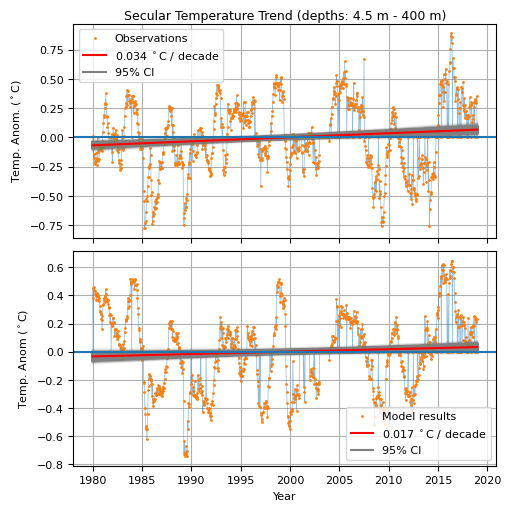

In [77]:
fact = 1

fig, axs = plt.subplots(2,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
axs = axs.ravel()
# fig.tight_layout(pad=0.1)

# obs_gt4mtemp = obs_gt4mtemp.values # if

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_gt4mtemp,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_gt4mtemp)]
y = obs_gt4mtemp[~np.isnan(obs_gt4mtemp)]
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
axs[0].plot(x, y, '.', label='Observations', markersize=2)
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000

bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)


axs[0].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')


axs[1].plot(tyr,mod_gt4mtemp,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_gt4mtemp)]
y = mod_gt4mtemp[~np.isnan(mod_gt4mtemp)]
axs[1].plot(x, y, '.', label='Model results', markersize=2)

# bootstrap analysis
bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")


# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        # get label for legend
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

axs[1].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')

# reorder legend
plt.sca(axs[0])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[0].axhline(y=0)
axs[0].grid()

# reorder legend
plt.sca(axs[1])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[1].axhline(y=0)
axs[1].grid()

axs[0].set_title('Secular Temperature Trend (depths: 4.5 m - 400 m)', fontsize=9, pad=3)
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].tick_params(axis='y', labelsize=8)
axs[1].tick_params(axis='x', labelbottom=True, labelsize=8)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel('Year', fontsize=8)
axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)


Original slope: 0.0078
95% Confidence Interval: 0.0052 to 0.0103
Is the trend significant at the 95% level? Yes
Original slope: 0.0057
95% Confidence Interval: 0.0034 to 0.0080
Is the trend significant at the 95% level? Yes


Text(0, 0.5, 'Temp. Anom ($^\\circ$C)')

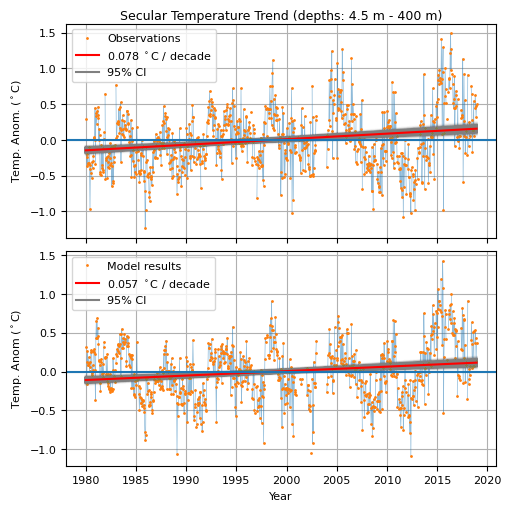

In [9]:
fact = 1

fig, axs = plt.subplots(2,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
axs = axs.ravel()
# fig.tight_layout(pad=0.1)

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_gt4mtemp.values)]
y = obs_gt4mtemp.values[~np.isnan(obs_gt4mtemp.values)]
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
axs[0].plot(x, y, '.', label='Observations', markersize=2)
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000

bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)


axs[0].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')


axs[1].plot(tyr,mod_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_gt4mtemp.values)]
y = mod_gt4mtemp.values[~np.isnan(mod_gt4mtemp.values)]
axs[1].plot(x, y, '.', label='Model results', markersize=2)

# bootstrap analysis
bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")


# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        # get label for legend
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

axs[1].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')

# reorder legend
plt.sca(axs[0])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[0].axhline(y=0)
axs[0].grid()

# reorder legend
plt.sca(axs[1])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[1].axhline(y=0)
axs[1].grid()

axs[0].set_title('Secular Temperature Trend (depths: 4.5 m - 400 m)', fontsize=9, pad=3)
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].tick_params(axis='y', labelsize=8)
axs[1].tick_params(axis='x', labelbottom=True, labelsize=8)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel('Year', fontsize=8)
axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)

In [125]:
values.shape

(850,)

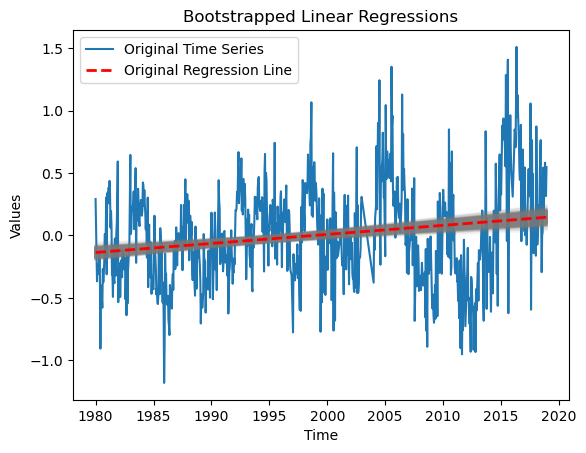

In [133]:
# Plot the original time series
plt.plot(time, values, label='Original Time Series')

# Plot the linear regression lines from the bootstrap samples
for i in range(n_iter):
    plt.plot(time, bootstrap_slopes[i] * time + bootstrap_biases[i], color='gray', alpha=0.05)

# Plot the line from the original regression
plt.plot(time, original_slope * time + original_bias, color='red', linestyle='--', linewidth=2, label='Original Regression Line')

# Add legend and labels
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Bootstrapped Linear Regressions')
plt.legend()

plt.show()

In [50]:
# import numpy as np
# import pandas as pd
# from sklearn.linear_model import LinearRegression

# # Generate sample time series data
# np.random.seed(0)
# time = np.arange(1, 101)
# values = 3 * time + np.random.normal(0, 10, size=100)

# # Fit linear regression to the original data
# regression = LinearRegression()
# regression.fit(time.reshape(-1, 1), values)

# # Function to compute the slope of the linear trend
# def compute_slope(x, y):
#     regression = LinearRegression()
#     regression.fit(x, y)
#     return regression.coef_[0]

# # Number of bootstrap iterations
# n_iterations = 1000

# # Initialize an array to store the slopes
# bootstrap_slopes = np.zeros(n_iterations)

# # Perform bootstrapping
# for i in range(n_iterations):
#     # Generate a bootstrap sample by resampling with replacement
#     indices = np.random.choice(len(values), len(values), replace=True)
#     bootstrap_sample = values[indices]
#     bootstrap_time = time[indices]

#     # Compute the slope of the linear trend on the bootstrap sample
#     bootstrap_slope = compute_slope(bootstrap_time.reshape(-1, 1), bootstrap_sample)
#     bootstrap_slopes[i] = bootstrap_slope

# # Compute the 95% confidence interval for the slopes
# confidence_interval = np.percentile(bootstrap_slopes, [2.5, 97.5])

# # Check if the original slope is within the confidence interval
# original_slope = regression.coef_[0]
# is_significant = (confidence_interval[0] <= original_slope <= confidence_interval[1])

# # Print the results
# print(f"Original slope: {original_slope:.2f}")
# print(f"95% Confidence Interval: {confidence_interval[0]:.2f} to {confidence_interval[1]:.2f}")
# print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")

Original slope: 2.97
95% Confidence Interval: 2.90 to 3.04
Is the trend significant at the 95% level? Yes


In [96]:
A

array([[1.98000000e+03, 1.00000000e+00],
       [1.98008333e+03, 1.00000000e+00],
       [1.98012500e+03, 1.00000000e+00],
       ...,
       [2.01883333e+03, 1.00000000e+00],
       [2.01887500e+03, 1.00000000e+00],
       [2.01891667e+03, 1.00000000e+00]])